In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, trange
# from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch

%matplotlib inline

## Computation of Randomized Fourier features Kernels in Parallel

First, let's read in MNIST Data to use as an example, and truncate to the first $1000$ samples.

In [2]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

n,d = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

### Kernel Generation Function

We use random Fourier features to emulate a Gaussian kernel.

In [3]:
def generate_kernel(m=220, s=1/d):
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=2*s*np.eye(d), size=m) # m x d
    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return z1 @ z2.T / m
    return ker

In [4]:
parameters = (1/784) * np.arange(0.1,10,0.1)#range(0.1,0.3,0.1)
n_param = parameters.shape[0]
m = 220

## Testing parameters using CV: Deterministic Kernel, Series computation

The goal of these experiments is to test a range of parameters values and compare the time it takes for various methods to do that. First, we test each parameter value in series using a deterministic kernel with `sklearn.model_selection.GridSearchCV`.

C:\Users\Sean\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


133.7277917


Text(0, 0.5, 'Accuracy')

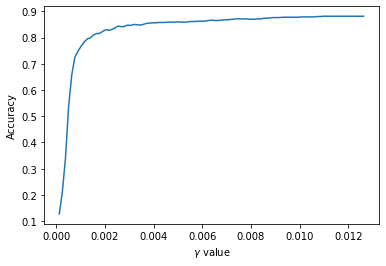

In [5]:
from sklearn.model_selection import GridSearchCV

start = perf_counter()

params = {'gamma': parameters}
svc = SVC(kernel='rbf')
clf = GridSearchCV(svc, params, cv=3)
clf.fit(X_train, y_train)

print(perf_counter() - start)

plt.plot(parameters, clf.cv_results_['mean_test_score'])
plt.xlabel('$\gamma$ value')
plt.ylabel('Accuracy')

## Testing parameters using CV: random Fourier features, Parallel computation

The random Fourier features method has another upshot: since the kernel matrix is approximated by
$$\hat{K} = \frac{1}{m}z(X)z(X)^T\,,$$
we are effectively approximating the kernel by matrix multiplication. Thus, we may parallelize this code, using _batch matrix multiplication_. We used `torch.bmm` to perform this.

37.825689100000005


Text(0, 0.5, 'Accuracy')

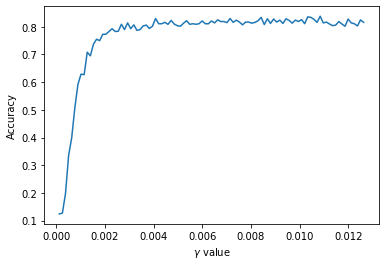

In [6]:
from sklearn.model_selection import StratifiedKFold


# X_train is train_batch x d
# X_test is test_batch x d

n_cv = 3

scores = np.empty((n_cv,n_param))

start = perf_counter()

skf = StratifiedKFold(n_splits = n_cv)
for i,(train_index, test_index) in enumerate(skf.split(X,y)):
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    
    # m x d x n_param
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=2*np.eye(d), size=(n_param, m)).transpose(1,2,0) * np.sqrt(parameters)

    # n_param x m x 1
    b = np.random.uniform(low=0, high=2*np.pi, size=(n_param,m,1))

    # Wtranspose below is n_param x m x d, X_train.T is d x train_batch, their product is n_param x m x train_batch

    placeholder = np.cos(np.dot(W.transpose(2,0,1), X_tr.T) + b) # n_param x m x train_batch

    z11 = torch.from_numpy(placeholder.transpose(0,2,1)) # n_param x train_batch x m
    z2 = torch.from_numpy(placeholder.transpose(0,1,2)) # n_param x m x train_batch

    z12 = torch.from_numpy(np.cos(np.dot(W.transpose(2,0,1), X_te.T) + b).transpose(0,2,1)) # n_param x test_batch x m

    out1 = (1/m) * np.asarray(torch.bmm(z11, z2)) # n_param x train_batch x train_batch
    out2 = (1/m) * np.asarray(torch.bmm(z12, z2)) # n_param x test_batch x train_batch

    for j in range(n_param):
        svm = SVC(kernel='precomputed')
        svm.fit(out1[j], y_tr)
        scores[i,j] = svm.score(out2[j], y_te)

totaltime = perf_counter() - start

print(totaltime)
plt.plot(parameters, np.mean(scores, axis=0))
plt.xlabel('$\gamma$ value')
plt.ylabel('Accuracy')

In [7]:
randmeans = np.mean(scores,axis=0)
detmeans = clf.cv_results_['mean_test_score']

In [8]:
#Error of results
np.linalg.norm(randmeans-detmeans) / np.linalg.norm(detmeans)

0.08716267658268868

In [9]:
#Check where random is maximized, and identify the order of that index in detmeans

random_max_idx = np.argmax(randmeans)

det_val_for_best_rand = detmeans[random_max_idx]

sorted_unique_det = np.unique(np.sort(detmeans))[::-1]

rank = np.where(sorted_unique_det == det_val_for_best_rand)[0][0]

print(f'Best random param value was the {rank}th best det param value')
print(f'Difference in accuracy between best random and best det is {np.max(detmeans)-np.max(randmeans)}')

Best random param value was the 1th best det param value
Difference in accuracy between best random and best det is 0.04310628874450617


## Testing parameters using CV: random Fourier features, Series computation

We compare our previous results to computing the random Fourier features kernels in series, and we note an almost $100\%$ speedup using the parallel method-- this may be attributed to the fact that the machine on which this code was ran had $2$ cores.

94.22474989999998


Text(0, 0.5, 'Accuracy')

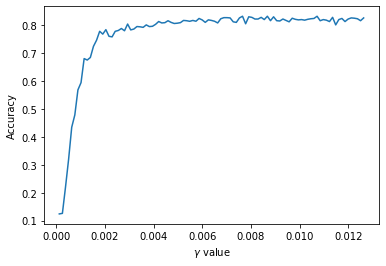

In [10]:
# X_train is train_batch x d
# X_test is test_batch x d

n_cv = 3

scores_cv_rnd_np = np.empty((n_cv,n_param))

start = perf_counter()

skf = StratifiedKFold(n_splits = n_cv)
for i,(train_index, test_index) in enumerate(skf.split(X,y)):
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    
    for j,val in enumerate(parameters):
        svm = SVC(kernel=generate_kernel(s=val))
        svm.fit(X_tr, y_tr)
        scores_cv_rnd_np[i,j] = svm.score(X_te, y_te)


totaltime = perf_counter() - start

print(totaltime)
plt.plot(parameters, np.mean(scores_cv_rnd_np, axis=0))
plt.xlabel('$\gamma$ value')
plt.ylabel('Accuracy')